# Introduction

One of the most difficult tasks in computer vision is creating new images from existing ones. The introduction of deep learning techniques made this task feasible, attracting the researcher to create new images. Many other applications, such as object reconstruction, data augmentation, and fugitive recognition, benefit from the creation of new images.

Because of their tremendous progress over the last decade, deep learning-based generative models have gained increasing attention. There are two major families of models that deserve special attention among these: Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs).

VAEs, a generative model similar to GANs, combine the benefits of the Bayesian method and deep learning. It is based on elegant mathematics, is simple to understand, and performs admirably. Because of its ability to extract disentangled latent variables, it has a broader meaning than the general generative model.

A VAE can be defined as being an autoencoder whose training is regularized to avoid overfitting and ensure that the latent space has good properties that enable the generative process. In this notebook, VAE will be used to generate images based on the CIFAR10 dataset. Fully Connected Variational Autoencoder (FCVAE) and Conditional Variational Autoencoder (CVAE) will be used (CVAE). To evaluate the results, I will use the Fréchet Inception Distance (FID) and Kernel Inception Distance (KID) metrics. 


## Variational Autoencoder

In this notebook, we will implement a variational autoencoder and a conditional variational autoencoder and apply them to the CIFAR10 dataset. An autoencoder seeks to learn a latent representation of our training images by using unlabeled data and learning to reconstruct its inputs. The *variational autoencoder* extends this model by adding a probabilistic spin to the encoder and decoder, allowing us to sample from the learned distribution of the latent space to generate new images at inference time.

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.


In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import sys
import time, os

os.environ["TZ"] = "US/Eastern"
time.tzset()

from vae import hello_vae
hello_vae()

from a6_helper import hello_helper
hello_helper()

Hello from vae.py!
Hello from a6_helper.py!


Load several useful packages that are used in this notebook:

In [7]:
from eecs598.grad import rel_error
from eecs598.utils import reset_seed
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [8]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Dataset

## Load CIFAR-10 Dataset


We will be working on the CIFAR10 dataset here. The CIFAR-10 dataset contains 60000 32x32 color images organized into 10 classes, each with 6000 images. There are 50,000 training and 10,000 test images.
The dataset is divided into five training batches and one test batch, each of which contains ten thousand images. The test batch contains exactly 1000 images from each class, chosen at random. The remaining images are distributed in random order to the training batches, but some training batches may contain more images from one class than another. The training batches each contain exactly 5000 images from each class.  Torchvision includes many built-in datasets in the torchvision.datasets module, as well as utility classes for creating your own datasets. We will use the PyTorch CIFAR10 wrapper to download and load the CIFAR10 dataset to simplify our code here. More information about the interface can be found in the [documentation]. The data will be saved in the 'CIFAR10_data' folder. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py) for more information about the interface. 

In [22]:
from a6_helper import show_images
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='CIFAR10_data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='CIFAR10_data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


## Visualize dataset

Let's take a look at the images in the CIFAR10 dataset.


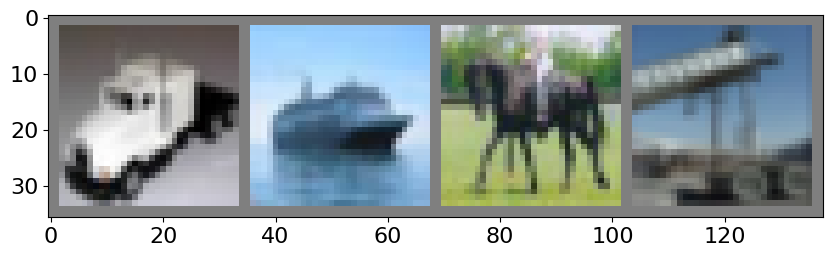

truck ship  horse truck


In [33]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(image):
    image = image / 2 + 0.5     
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Methods

## Fully Connected VAE

The first VAE implementation will be made up entirely of fully connected layers. We wll flatten the features of our input's '3 x 32 x 32' shape to create an input dimension size of 3072. I'll define the Encoder and Decoder models in this section. And, to train the first VAE, we will use the reparametrization trick, forward pass, and loss function.

## FC-VAE Encoder

Now lets start building our fully-connected VAE network. We'll start with the encoder, which will take our images as input (after flattening C,H,W to D shape) and pass them through a three Linear+ReLU layers. We'll use this hidden dimension representation to predict both the posterior mu and posterior log-variance using two separate linear layers (both shape (N,Z)). 

Note that we are calling this the 'logvar' layer because we'll use the log-variance (instead of variance or standard deviation) to stabilize training. This will specifically matter more when you compute reparametrization and the loss function later. 

*Define an `encoder`, `hidden_dim` (H), `mu_layer`, and `logvar_layer` in the initialization of the VAE class in `vae.py`. Use nn.Sequential to define the encoder, and separate Linear layers for the mu and logvar layers. In all of these layers, H will be a hidden dimension you set and will be the same across all encoder and decoder layers. Architecture for the encoder is described below:*


 * `Flatten` (Hint: nn.Flatten)
 * Fully connected layer with input size 784 (`input_size`) and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`


## FC-VAE Decoder

We'll now define the decoder, which will take the latent space representation and generate a reconstructed image. The architecture is as follows: 

 * Fully connected layer with input size as the latent size (Z) and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size 3072 (`input_size`)
 * `Sigmoid`
 * `Unflatten` (nn.Unflatten)




## Reparametrization 




Now we'll apply a reparametrization trick in order to estimate the posterior $z$ during our forward pass, given the $\mu$ and $\sigma^2$ estimated by the encoder. A simple way to do this could be to simply generate a normal distribution centered at our  $\mu$ and having a std corresponding to our $\sigma^2$. However, we would have to backpropogate through this random sampling that is not differentiable. Instead, we sample initial random data $\epsilon$ from a fixed distrubtion, and compute $z$ as a function of ($\epsilon$, $\sigma^2$, $\mu$). Specifically:

$z = \mu + \sigma\epsilon$

We can easily find the partial derivatives w.r.t $\mu$ and $\sigma^2$ and backpropagate through $z$. If $\epsilon = \mathcal{N} (0,1)$, then it's easy to verify that the result of our forward pass calculation will be a distribution centered at $\mu$ with variance $\sigma^2$.


In [12]:
reset_seed(0)
from vae import reparametrize
latent_size = 15
size = (1, latent_size)
mu = torch.zeros(size)
logvar = torch.ones(size)

z = reparametrize(mu, logvar)

expected_mean = torch.FloatTensor([-0.4363])
expected_std = torch.FloatTensor([1.6860])
z_mean = torch.mean(z, dim=-1)
z_std = torch.std(z, dim=-1)
assert z.size() == size

print('Mean Error', rel_error(z_mean, expected_mean))
print('Std Error', rel_error(z_std, expected_std))

Mean Error 5.639056398351415e-05
Std Error 7.1412955526273885e-06


## FC-VAE Forward

Complete the VAE class by writing the forward pass. The forward pass should pass the input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the latent space z, and finally pass z into the decoder to generate an image.



## Loss Function

Before we're able to train our final model, we'll need to define our loss function. As seen below, the loss function for VAEs contains two terms: A reconstruction loss term (left) and KL divergence term (right). 

$-E_{Z~q_{\phi}(z|x)}[log p_{\theta}(x|z)] + D_{KL}(q_{\phi}(z|x), p(z)))$

Note that this is the negative of the variational lowerbound shown in lecture--this ensures that when we are minimizing this loss term, we're maximizing the variational lowerbound. The reconstruction loss term can be computed by simply using the binary cross entropy loss between the original input pixels and the output pixels of our decoder (Hint: `nn.functional.binary_cross_entropy`). The KL divergence term works to force the latent space distribution to be close to a prior distribution (we're using a standard normal gaussian as our prior).

To help you out, we've derived an unvectorized form of the KL divergence term for you.
Suppose that $q_\phi(z|x)$ is a $Z$-dimensional diagonal Gaussian with mean $\mu_{z|x}$ of shape $(Z,)$ and standard deviation $\sigma_{z|x}$ of shape $(Z,)$, and that $p(z)$ is a $Z$-dimensional Gaussian with zero mean and unit variance. Then we can write the KL divergence term as:

$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{J} (1 + log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j}$)

It's up to you to implement a vectorized version of this loss that also operates on minibatches.
You should average the loss across samples in the minibatch.

Implement `loss_function` in `vae.py` and verify your implementation below. Your relative error should be less than or equal to `1e-5`



In [13]:
from vae import loss_function
size = (1,15)

image = torch.sigmoid(torch.FloatTensor([[2,5], [6,7]]).unsqueeze(0).unsqueeze(0))
image_hat = torch.sigmoid(torch.FloatTensor([[1,10], [9,3]]).unsqueeze(0).unsqueeze(0))

expected_out = torch.tensor(8.5079)
mu, logvar = torch.ones(size), torch.zeros(size)
out = loss_function(image, image_hat, mu, logvar)
print('Loss error', rel_error(expected_out,out))

Loss error 2.1297676389877955e-06



## Train a model

Now that we have our VAE defined and loss function ready, lets train our model! Our training script is provided  in `a6_helper.py`, and we have pre-defined an Adam optimizer, learning rate, and # of epochs for you to use. 

Training for 10 epochs should take ~2 minutes and your loss should be less than 120.

In [32]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


[1,  2000] loss: 2.236
[1,  4000] loss: 1.915
[1,  6000] loss: 1.729
[1,  8000] loss: 1.589
[1, 10000] loss: 1.494
[1, 12000] loss: 1.477
[2,  2000] loss: 1.382
[2,  4000] loss: 1.357
[2,  6000] loss: 1.321
[2,  8000] loss: 1.287
[2, 10000] loss: 1.284
[2, 12000] loss: 1.241


## Visualize results
After we've trained our VAE network, we can use its power to generate new training examples. We simply use the decoder in this process: we initialize some random distribution for our latent spaces z and generate new examples by passing these latent spaces into the decoder. To generate new images, run the cell below! Many of the images should be visually recognisable, though some may be blurry or poorly formed. These results will be improved in our next model.

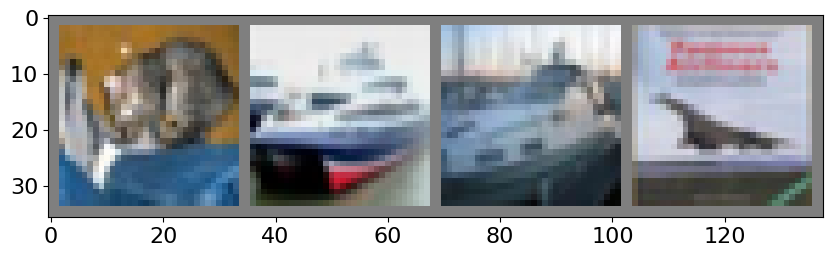

GroundTruth:  cat   ship  ship  plane


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Latent Space Interpolation

As a final visual test of our trained VAE model, we can perform interpolation in latent space. We generate random latent vectors $z_0$ and $z_1$, and linearly interpolate between them; we run each interpolated vector through the trained generator to produce an image.

Each row of the figure below interpolates between two random vectors. For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the image it is modeling.

In [16]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  plane ship 


# Conditional FC-VAE 

The second model you'll develop will be very similar to the FC-VAE, but with a slight conditional twist to it. We'll use what we know about the labels of each MNIST image, and *condition* our latent space and image generation on the specific class. Instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$ we have $q_{\phi} (z|x,c)$  and $p_{\phi}(x|z, c)$

This will allow us to do some powerful conditional generation at inference time. We can specifically choose to generate more 1s, 2s, 9s, etc. instead of simply generating new images randomly.

## Define Network with class input

Our CVAE architecture will be the same as our FC-VAE architecture, except we'll now add a one-hot label vector to both the x input (in our case, the flattened image dimensions) and the z latent space. 

If our one-hot vector is called `c`, then `c[label] = 1` and `c = 0` elsewhere.

For the `CVAE` class in `vae.py` use the same FC-VAE architecture implemented in the last network with the following modifications:

1. Modify the first linear layer of your `encoder` to take in not only the flattened input image, but also the one-hot label vector `c`
2. Modify the first layer of your `decoder` to project the latent space + one-hot vector to the `hidden_dim`
3. Lastly, implement the `forward` pass to combine the flattened input image with the one-hot vectors (`torch.cat`) before passing them to the `encoder` and combine the latent space with the one-hot vectors (`torch.cat`) before passing them to the `decoder`

## Train model

Using the same training script, let's now train our CVAE! 

Training for 10 epochs should take ~2 minutes and your loss should be less than 120.

In [25]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 56 %


## Visualize Results

Let's see the results now


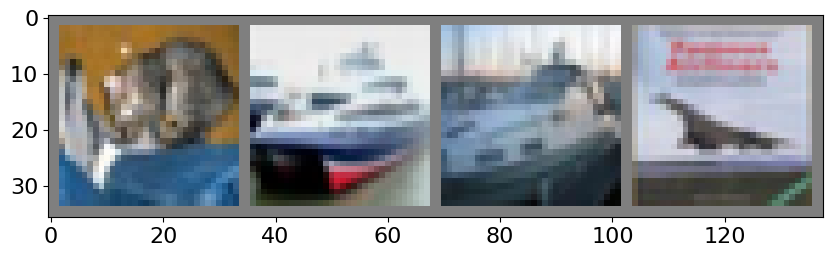

In [29]:

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))

## Frechet Inception Distance
FID is a performance metric that computes the difference between the feature vectors of real and fake images (Generated by the generator). The lower the FID score, the higher the quality of the images generated by the generator is and the more similar they are to real ones. The feature vectors of images are used in FID.

In [35]:
from torch import nn
from torchvision.models import inception_v3
import cv2
import multiprocessing
import numpy as np
import glob
import os
from scipy import linalg



class PartialInceptionNetwork(nn.Module):

    def __init__(self, transform_input=True):
        super().__init__()
        self.inception_network = inception_v3(pretrained=True)
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)
        self.transform_input = transform_input

    def output_hook(self, module, input, output):
        self.mixed_7c_output = output

    def forward(self, x):
        assert x.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                             ", but got {}".format(x.shape)
        x = x * 2 -1 # Normalize to [-1, 1]
        self.inception_network(x)
        activations = self.mixed_7c_output
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1,1))
        activations = activations.view(x.shape[0], 2048)
        return activations


def get_activations(images, batch_size):
    assert images.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                              ", but got {}".format(images.shape)
    num_images = images.shape[0]
    inception_network = PartialInceptionNetwork()
    inception_network = to_cuda(inception_network)
    inception_network.eval()
    n_batches = int(np.ceil(num_images  / batch_size))
    inception_activations = np.zeros((num_images, 2048), dtype=np.float32)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)
        ims = images[start_idx:end_idx]
        ims = to_cuda(ims)
        activations = inception_network(ims)
        activations = activations.detach().cpu().numpy()
        assert activations.shape == (ims.shape[0], 2048), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 2048), activations.shape)
        inception_activations[start_idx:end_idx, :] = activations
    return inception_activations



def calculate_activation_statistics(images, batch_size):
    act = get_activations(images, batch_size)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)
    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def preprocess_image(im):
    assert im.shape[2] == 3
    assert len(im.shape) == 3
    if im.dtype == np.uint8:
        im = im.astype(np.float32) / 255
    im = cv2.resize(im, (299, 299))
    im = np.rollaxis(im, axis=2)
    im = torch.from_numpy(im)
    assert im.max() <= 1.0
    assert im.min() >= 0.0
    assert im.dtype == torch.float32
    assert im.shape == (3, 299, 299)
    return im


def preprocess_images(images, use_multiprocessing):
    if use_multiprocessing:
        with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
            jobs = []
            for im in images:
                job = pool.apply_async(preprocess_image, (im,))
                jobs.append(job)
            final_images = torch.zeros(images.shape[0], 3, 299, 299)
            for idx, job in enumerate(jobs):
                im = job.get()
                final_images[idx] = im#job.get()
    else:
        final_images = torch.stack([preprocess_image(im) for im in images], dim=0)
    assert final_images.shape == (images.shape[0], 3, 299, 299)
    assert final_images.max() <= 1.0
    assert final_images.min() >= 0.0
    assert final_images.dtype == torch.float32
    return final_images


def calculate_fid(images1, images2, use_multiprocessing, batch_size):
    images1 = preprocess_images(images1, use_multiprocessing)
    images2 = preprocess_images(images2, use_multiprocessing)
    mu1, sigma1 = calculate_activation_statistics(images1, batch_size)
    mu2, sigma2 = calculate_activation_statistics(images2, batch_size)
    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid


def load_images(path):
    image_paths = []
    image_extensions = ["png", "jpg"]
    for ext in image_extensions:
        print("Looking for images in", os.path.join(path, "*.{}".format(ext)))
        for impath in glob.glob(os.path.join(path, "*.{}".format(ext))):
            image_paths.append(impath)
    first_image = cv2.imread(image_paths[0])
    W, H = first_image.shape[:2]
    image_paths.sort()
    image_paths = image_paths
    final_images = np.zeros((len(image_paths), H, W, 3), dtype=first_image.dtype)
    for idx, impath in enumerate(image_paths):
        im = cv2.imread(impath)
        im = im[:, :, ::-1] # Convert from BGR to RGB
        assert im.dtype == final_images.dtype
        final_images[idx] = im
    return final_images


In [36]:
from optparse import OptionParser
    
parser = OptionParser()
parser.add_option("--p1", "--path1", dest="path1", 
                       help="dc_gan_cifar_results")
parser.add_option("--p2", "--path2", dest="path2", 
                       help="dc_gan_results")
parser.add_option("--multiprocessing", dest="use_multiprocessing",
                      help="Toggle use of multiprocessing for image pre-processing. Defaults to use all cores",
                      default=False,
                      action="store_true")
parser.add_option("-b", "--batch-size", dest="batch_size",
                      help="Set batch size to use for InceptionV3 network",
                      type=int)
    
options, _ = parser.parse_args()
assert options.path1 is not None, "--path1 is an required option"
assert options.path2 is not None, "--path2 is an required option"
assert options.batch_size is not None, "--batch_size is an required option"
images1 = load_images(options.path1)
images2 = load_images(options.path2)
fid_value = calculate_fid(images1, images2, options.use_multiprocessing, options.batch_size)
print(fid_value)

<Option at 0x145c30fc2370: -b/--batch-size>

## Kernel inception distance
For measuring image generation quality, the Kernel Inception Distance (KID) metric was proposed as a replacement for the popular Frechet Inception Distance (FID). Both metrics assess the difference in the representation space generated and training distributions of an InceptionV3 network pretrained on ImageNet.

According to the paper, KID was proposed because FID lacks an unbiased estimator and its expected value is higher when measured on fewer images. KID is better suited to small datasets because its expected value is independent of the number of samples measured. In my experience, it is also computationally lighter, numerically more stable, and easier to implement because it can be estimated on a per-batch basis.

# Conclusion :

In this notebook, we have seen the variational autoencoder (VAE) and
some of its extensions. Like, Fully Connected Variational Autoencoder (FCVAE) and Conditional Variational Autoencoder (CVAE) will be used (CVAE). VAE's architecture consists of two components: encoder and decoder. Input data is encoded into
hidden states by the encoder. In other words, the encoder projects the input data onto a lower-dimension vector, each element of which has its own distribution. Then, from such distributions, a vector is sampled to obtain a specific input (hidden state) to the decoder. Finally, the decoder attempts to decode its input to
the encoder's input data. Unlike GAN, which has predefined hidden state distributions, VAE learns the hidden state distributions p(z) during the process.

FCVAE: First implementation of VAE is fully connected layers. We have  taken the 3 x 32 x 32 shape of our input
and flatten the features to create an input dimension size of 3072. Encoder will take our images as input and
pass them through three Linear+ReLU layers. Reparameterization trick in order to estimate the posterior 𝑧z
during our forward pass, given the 𝜇μ and 𝜎2σ2 estimated by the encoder. The forward pass should pass the
input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the
latent space z, and finally pass z into the decoder to generate an image.

Conditional Variational Autoencoder (CVAE): It is an extension of Variational Autoencoder. The
conditional variational autoencoder has an extra input to both the encoder and the decoder. Here we will
condition our latent space and image generation on the specific class. CVAE architecture will be the same
as our FC-VAE architecture, except we'll now add a one-hot label vector to both the x input and the z latent
space.
